# Reporte Técnico: Selección e Implementación de Modelos

---

## 1. Introducción

En operaciones de Contugas, monitorear presión, volumen y temperatura es crítico.  
**Pregunta de negocio**: ¿Qué registros representan un comportamiento anómalo?  
Sin etiquetas operativas, definimos anomalía puramente sobre datos históricos, combinando:  
1. **Rolling IQR** per‐cliente → pseudo‐etiquetas univariadas.  
2. **Ensemble** de 3 modelos no supervisados (IF, LOF, OCSVM) → etiquetas finales.  

Los requerimientos R3–R6 (sensibilidad, estabilidad, separación y coherencia) guían este desarrollo.

---

## 2. Propuesta de Modelos

### 2.1 Modelos Considerados

| Modelo                | Ventajas                                     | Desventajas                              |
|-----------------------|----------------------------------------------|------------------------------------------|
| Isolation Forest (IF) | Escalable, genera score, no requiere etiquetas | Sensible a `contamination` y `n_estimators` |
| Local Outlier Factor (LOF) | Detecta anomalías locales                 | Más costoso, necesita `novelty=True`     |
| One-Class SVM (OCSVM) | Flexible (kernels)                           | Lento, sensible a `nu` y `gamma`         |

**Estrategia**: entrenar cada modelo sobre la misma matriz de features,  
recoger labels y scores, luego aplicar un **ensemble** por mayoría (≥2 de 3).

---

## 3. Desarrollo

### 3.1 Instalación de dependencias

```bash
pip install pandas numpy scikit-learn matplotlib seaborn joblib


### 3.1 Lectura y EDA inicial

In [7]:
import pandas as pd
import numpy as np

df = pd.read_excel("datos_clientes.xlsx")
print(df.shape)
df.head()

(847960, 5)


,Fecha,Presion,Temperatura,Volumen,Cliente
0,2019-01-14 00:00:00,17.732563,28.209354,20.969751,CLIENTE1
1,2019-01-14 01:00:00,17.747776,28.518614,17.845739,CLIENTE1
2,2019-01-14 02:00:00,17.758916,28.230191,20.975914,CLIENTE1
3,2019-01-14 03:00:00,17.727940,27.811509,20.592299,CLIENTE1
4,2019-01-14 04:00:00,17.746484,27.795293,21.690626,CLIENTE1


### 3.3 Feature Engineering y Preprocesamiento

In [8]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Asegurar datetime
    df['Fecha'] = pd.to_datetime(df['Fecha'])
    df = df.sort_values(['Cliente','Fecha']).reset_index(drop=True)

    # 1. Temporales
    df['hour']        = df['Fecha'].dt.hour
    df['day_of_week'] = df['Fecha'].dt.dayofweek
    df['is_weekend']  = (df['day_of_week'] >= 5).astype(int)

    # 2. Cíclicas
    df['sin_hour']        = np.sin(2*np.pi * df['hour']       / 24)
    df['cos_hour']        = np.cos(2*np.pi * df['hour']       / 24)
    df['sin_day_of_week'] = np.sin(2*np.pi * df['day_of_week']/ 7)
    df['cos_day_of_week'] = np.cos(2*np.pi * df['day_of_week']/ 7)

    # 3. Cliente one-hot
    df = pd.get_dummies(df, columns=['Cliente'], prefix='C')

    # 4. Ratios y productos físicos
    df['ratio_pres_vol']  = df['Presion']    / (df['Volumen']    + 1e-6)
    df['ratio_pres_temp'] = df['Presion']    / (df['Temperatura'] + 1e-6)
    df['ratio_vol_temp']  = df['Volumen']    / (df['Temperatura'] + 1e-6)
    df['prod_pres_vol']   = df['Presion'] * df['Volumen']
    df['prod_pres_temp']  = df['Presion'] * df['Temperatura']
    df['prod_vol_temp']   = df['Volumen'] * df['Temperatura']

    # 5. Transformaciones no lineales
    df['log_presion']     = np.log1p(df['Presion'])
    df['log_volumen']     = np.log1p(df['Volumen'])
    df['log_temperatura'] = np.log1p(df['Temperatura'])

    # 6. Estadísticos de la fila
    trio = df[['Presion','Volumen','Temperatura']]
    df['mean_three'] = trio.mean(axis=1)
    df['std_three']  = trio.std(axis=1)
    df['max_three']  = trio.max(axis=1)
    df['min_three']  = trio.min(axis=1)

    # 7. Imputación final
    num_cols = df.select_dtypes(include=[np.number]).columns
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())

    return df

def prepare_ml_matrix(df: pd.DataFrame) -> pd.DataFrame:
    drop_cols = ['Fecha']
    return df[[c for c in df.columns if c not in drop_cols]]

# Generar features
df_add = add_features(df)
X  = prepare_ml_matrix(df_add)

print("Matriz de features:", X.shape)
X.head()

c:\ProgramData\Anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Matriz de features: (847960, 43)


,Presion,Temperatura,Volumen,hour,day_of_week,is_weekend,sin_hour,cos_hour,sin_day_of_week,cos_day_of_week,...,prod_pres_vol,prod_pres_temp,prod_vol_temp,log_presion,log_volumen,log_temperatura,mean_three,std_three,max_three,min_three
0,17.732563,28.209354,20.969751,0,0,0,0.000000,1.000000,0.0,1.0,...,371.847437,500.224155,591.543116,2.930263,3.089667,3.374489,22.303889,5.364301,28.209354,17.732563
1,17.747776,28.518614,17.845739,1,0,0,0.258819,0.965926,0.0,1.0,...,316.722181,506.141978,508.935750,2.931075,2.936287,3.385021,21.370710,6.190461,28.518614,17.747776
2,17.758916,28.230191,20.975914,2,0,0,0.500000,0.866025,0.0,1.0,...,372.509500,501.337594,592.154045,2.931669,3.089947,3.375202,22.321674,5.363786,28.230191,17.758916
3,17.727940,27.811509,20.592299,3,0,0,0.707107,0.707107,0.0,1.0,...,365.059047,493.040762,572.702903,2.930017,3.072337,3.360775,22.043916,5.196151,27.811509,17.727940
4,17.746484,27.795293,21.690626,4,0,0,0.866025,0.500000,0.0,1.0,...,384.932338,493.268723,602.897309,2.931006,3.121952,3.360212,22.410801,5.062967,27.795293,17.746484


### 3.4 Rolling IQR – Pseudo‐etiquetas

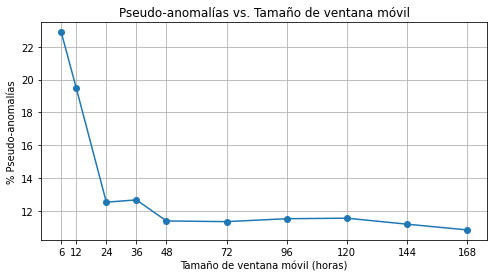

In [15]:
import matplotlib.pyplot as plt

def rolling_iqr_mask(df, variable, window):
    q1 = df.groupby('Cliente')[variable] \
           .transform(lambda x: x.rolling(window,1).quantile(0.25))
    q3 = df.groupby('Cliente')[variable] \
           .transform(lambda x: x.rolling(window,1).quantile(0.75))
    iqr = q3 - q1
    mask = (df[variable] < (q1 - 1.5*iqr)) | (df[variable] > (q3 + 1.5*iqr))
    return mask.astype(int)


# Evaluar distintos tamaños de ventana (en horas)
windows = [6, 12, 24, 36, 48, 72, 96, 120, 144, 168]
percentages = []

for w in windows:
    mask_pres = rolling_iqr_mask(df, 'Presion', w)
    mask_vol  = rolling_iqr_mask(df, 'Volumen', w)
    mask_temp = rolling_iqr_mask(df, 'Temperatura', w)
    pseudo = ((mask_pres + mask_vol + mask_temp) >= 1).astype(int)
    percentages.append(pseudo.mean() * 100)

# Graficar
plt.figure(figsize=(8, 4))
plt.plot(windows, percentages, marker='o', linestyle='-')
plt.xlabel('Tamaño de ventana móvil (horas)')
plt.ylabel('% Pseudo-anomalías')
plt.title('Pseudo-anomalías vs. Tamaño de ventana móvil')
plt.xticks(windows)
plt.grid(True)
plt.show()

In [16]:
# Definir ventana (48 horas = 2 días)
window = 48
mask_pres = rolling_iqr_mask(df,'Presion',window)
mask_vol  = rolling_iqr_mask(df,'Volumen',window)
mask_temp = rolling_iqr_mask(df,'Temperatura',window)

df['pseudo_anom'] = ((mask_pres + mask_vol + mask_temp) >= 1).astype(int)
print("Pseudo‐etiquetas univariadas %anom:", df['pseudo_anom'].mean()*100)

Pseudo‐etiquetas univariadas %anom: 11.378131043917165


### 3.5 Entrenamiento y Calibración de Modelos 

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

def train_and_predict(det_name, X, contamination, random_state=42):
    scaler = StandardScaler().fit(X)
    Xs = scaler.transform(X)
    if det_name=='if':
        model = IsolationForest(contamination=contamination, random_state=random_state)
    elif det_name=='lof':
        model = LocalOutlierFactor(n_neighbors=20,
                                   contamination=contamination,
                                   novelty=True)
    elif det_name=='ocsvm':
        model = OneClassSVM(nu=contamination, kernel='rbf', gamma='auto')
    else:
        raise ValueError(det_name)
    model.fit(Xs)
    labels = model.predict(Xs)
    scores = model.decision_function(Xs)
    return scaler, model, labels, scores

# Grid search
model_names = ['if','lof','ocsvm']
cont_grid = [0.08, 0.10, 0.1138, 0.12, 0.15]
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

cv_results = []
for name in model_names:
    for c in cont_grid:
        fold_scores = []
        for train_idx, test_idx in tscv.split(X):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_pseudo_test   = df['pseudo_anom'].iloc[test_idx].values

            # entrenar solo con train
            _, model, _, _ = train_and_predict(name, X_train, contamination=c)
            # predecir sobre test
            scaler = StandardScaler().fit(X_train)
            Xs_test = scaler.transform(X_test)
            y_pred = model.predict(Xs_test)
            y_flag = (y_pred == -1).astype(int)

            # métrica: acuerdo con pseudo-etiquetas en test
            acc = (y_flag == y_pseudo_test).mean()
            fold_scores.append(acc*100)

        cv_results.append({
            'modelo': name,
            'contamination': c,
            'cv_mean_coincidencia(%)': np.mean(fold_scores),
            'cv_std(%)': np.std(fold_scores)
        })

cv_df = pd.DataFrame(cv_results)
display(cv_df.pivot('contamination','modelo','cv_mean_coincidencia(%)').round(1))
